 # House price prediction with 3 popular algorithm
 - Random Forest
 - xgboost
 - lgmboost

 ** Also randomized search cv for parameter tunning best for beginner easy and simple code

 I will be improving this notebook in future

**1) Random Forest**

In [2]:
import pandas as pd

Load Libraries

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score ,r2_score ,mean_absolute_error,root_mean_squared_error,mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns



In [7]:
df = pd.read_csv('../input/dataset/house/train.csv')

X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=42)

In [8]:
def drop_not_used_columns(df):
    df.drop('Id', axis=1, inplace=True)
    # df.drop('SalePrice', axis=1, inplace=True)
    
    return df

def fill_na_val_cols(df):
    df["LotFrontage"] = df["LotFrontage"].fillna(df["LotFrontage"].median())
    df["MasVnrArea"] = df["MasVnrArea"].fillna(df["MasVnrArea"].median())
    df["GarageYrBlt"] = df["GarageYrBlt"].fillna(df["GarageYrBlt"].median())
    
    return df

def fill_na_enum_cols(df):
    for col in df.columns:
        if df[col].dtype == 'object' and df[col].isna().any():
            df[col] = df[col].fillna(df[col].mode()[0])
    return df


In [9]:
X_train = drop_not_used_columns(X_train)
X_train = fill_na_val_cols(X_train)
X_train = fill_na_enum_cols(X_train)

# test transform

X_test = drop_not_used_columns(X_test)
X_test = fill_na_val_cols(X_test)
X_test = fill_na_enum_cols(X_test)


In [210]:
print("Mean :", df["LotFrontage"].mean())
print("Mode :", df["LotFrontage"].mode()[0])
print("Median :", df["LotFrontage"].median())

Mean : 70.04995836802665
Mode : 60.0
Median : 69.0


**Starting Encoding**

(i) Label Encoding

In [10]:
# Define categorical columns to be target encoded
target_cat_cols = [
    "MSZoning", "Street", "Alley", "Utilities", "LotConfig", "Neighborhood",
    "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", "Heating",
    "CentralAir", "Electrical", "GarageType", "PavedDrive", "MiscFeature"
]

# Global encoder to be reused on test set
target_encoder = ce.TargetEncoder()

def target_encode_train(X_train, y_train):
    X_train = X_train.copy()
    
    for col in target_cat_cols:
        if col in X_train.columns:
            X_train[col] = X_train[col].astype(str)
        else:
            print(f"⚠️ Column {col} not found in X_train")

    # Fit once on all training columns
    target_encoder.fit(X_train[target_cat_cols], y_train)

    # Transform training data
    X_train[target_cat_cols] = target_encoder.transform(X_train[target_cat_cols])
    
    return X_train


def target_encode_test(X_test):
    X_test = X_test.copy()
    
    for col in target_cat_cols:
        if col in X_test.columns:
            X_test[col] = X_test[col].astype(str)
        else:
            print(f"⚠️ Column {col} not found in X_test")
    
    # Transform using fitted encoder
    X_test[target_cat_cols] = target_encoder.transform(X_test[target_cat_cols])
    
    return X_test

(ii) Ordinal Encoding

In [11]:
ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
ord_cat_cols = [
        "LotShape", "LandContour", "SaleCondition", "Condition1", "Condition2",
        "LandSlope", "Utilities", "BldgType", "HouseStyle", "RoofStyle", 
        "ExterQual", "ExterCond", "GarageQual", "GarageCond", "BsmtQual", 
        "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "HeatingQC", 
        "KitchenQual", "FireplaceQu", "Functional", "GarageFinish", 
        "PoolQC", "Fence", "SaleType","BsmtCond"
    ]

def ordinalEncoding(df):
    
    # Convert to string and encode
    df[ord_cat_cols] = df[ord_cat_cols].astype(str)
    df[ord_cat_cols] = ordinal_encoder.fit_transform(df[ord_cat_cols])
    return df

def ordinal_encode_test(df):
    
    df = df.copy()
    # Convert to string and encode using fitted encoder
    df[ord_cat_cols] = df[ord_cat_cols].astype(str)
    df[ord_cat_cols] = ordinal_encoder.transform(df[ord_cat_cols])

    return df

(iii) One Hot Encoder

In [12]:
hot_cols = ["Foundation"]

def oneHotEncoding(df):
# def oneHotEncoding(df, hot_cols):
    
    one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Ensure all columns are strings
    df[hot_cols] = df[hot_cols].astype(str)

    # Fit and transform
    encoded = one_hot_encoder.fit_transform(df[hot_cols])

    # Create column names
    encoded_cols = one_hot_encoder.get_feature_names_out(hot_cols)

    # Create encoded DataFrame
    encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)

    # Drop original categorical columns
    df = df.drop(columns=hot_cols)

    # Concatenate encoded columns
    df = pd.concat([df, encoded_df], axis=1)

    return df, one_hot_encoder

def one_hot_encode_test(df,encoder):
    df = df.copy()
    
    df[hot_cols] = df[hot_cols].astype(str)
    encoded = encoder.transform(df[hot_cols])
    
    encoded_cols = encoder.get_feature_names_out(hot_cols)
    
    encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)
    
    df = df.drop(columns=hot_cols)
    df = pd.concat([df, encoded_df], axis=1)
    return df

In [13]:
X_train = target_encode_train(X_train, y_train)
X_train, one_hot_encoder = oneHotEncoding(X_train)
X_train = ordinalEncoding(X_train)

In [14]:
X_test = one_hot_encode_test(X_test,one_hot_encoder)
X_test = ordinal_encode_test(X_test)
X_test = target_encode_test(X_test)


In [15]:
print(X_train.shape)
print(X_test.shape)

(1168, 84)
(292, 84)


In [ ]:

cols = []
df_summary =pd.DataFrame({
    'Column':cols,
    'Unique Count': [df[col].nunique() for col in cols],
    'Unique Values' : [df[col].unique() if df[col].nunique() <= 6 else 'more than 5 values' for col in cols]
    # columns
    # columns=cols,
    
})
# df_summary

In [21]:
y_train.isna().sum().any()

np.False_

Histogram of Sale Price

In [224]:
X_train.describe()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MoSold,YrSold,SaleType,SaleCondition,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood
count,1168.000000,1.168000e+03,1168.000000,1168.000000,1.168000e+03,1.168000e+03,1168.000000,1168.000000,1168.0,1.168000e+03,...,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000
mean,56.849315,1.814415e+05,70.279966,10689.642123,1.814415e+05,1.814415e+05,1.917808,2.794521,0.0,1.814415e+05,...,6.356164,2007.818493,7.497432,3.782534,0.099315,0.431507,0.445205,0.017123,0.004281,0.002568
std,42.531862,5.823259e-11,22.463709,10759.366198,5.823259e-11,5.823259e-11,1.414247,0.685687,0.0,5.823259e-11,...,2.670707,1.322639,1.587762,1.078243,0.299213,0.495499,0.497201,0.129786,0.065316,0.050637
min,20.000000,1.814415e+05,21.000000,1300.000000,1.814415e+05,1.814415e+05,0.000000,0.000000,0.0,1.814415e+05,...,1.000000,2006.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.814415e+05,60.000000,7587.250000,1.814415e+05,1.814415e+05,0.000000,3.000000,0.0,1.814415e+05,...,5.000000,2007.000000,8.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,1.814415e+05,70.000000,9600.000000,1.814415e+05,1.814415e+05,3.000000,3.000000,0.0,1.814415e+05,...,6.000000,2008.000000,8.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,1.814415e+05,79.000000,11700.000000,1.814415e+05,1.814415e+05,3.000000,3.000000,0.0,1.814415e+05,...,8.000000,2009.000000,8.000000,4.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,190.000000,1.814415e+05,313.000000,215245.000000,1.814415e+05,1.814415e+05,3.000000,3.000000,0.0,1.814415e+05,...,12.000000,2010.000000,8.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [339]:
model = RandomForestRegressor()


In [340]:
model.fit(X_train,y_train)

RandomForestRegressor()

In [342]:
y_predict = model.predict(X_test)

In [346]:
print(y_predict.shape)
print(y_test.shape)

(292,)
(292,)


In [351]:
#confusion matrix
mae = mean_absolute_error(y_test, y_predict)
mse = mean_squared_error(y_test, y_predict)
rmsq = root_mean_squared_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)
print(f"Mean Absolute Error :  {mae}")
print(f"Mean Squared Error {mse}")
print(f"RMS Error {rmsq}")
print(f"R2 Score {r2}")

# from sklearn.metrics import confusion_matrix
# confusion_matrix(y_test,y_predict)

Mean Absolute Error :  16986.045993150685
Mean Squared Error 829785631.844258
RMS Error 28805.999927866727
R2 Score 0.8918187298127236


In [41]:
test_df = pd.read_csv('../input/dataset/house/test.csv')

In [357]:
test_df.isna().any()

MSSubClass       False
MSZoning         False
LotFrontage      False
LotArea          False
Street           False
                 ...  
MiscVal          False
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
Length: 79, dtype: bool

In [39]:
test_df = drop_not_used_columns(test_df)
test_df = fill_na_enum_cols(test_df)
test_cols = fill_na_val_cols(test_df)

test_df = one_hot_encode_test(test_df,one_hot_encoder)
test_df = ordinal_encode_test(test_df)
test_df = target_encode_test(test_df)

In [359]:
submission = model.predict(test_df)

In [361]:
# df.to_csv(s)
submission_df = pd.DataFrame({
    'Id':test_df["Id"],
    'SalePrice':submission
})

In [362]:
submission_df

,Id,SalePrice
0,1461,125353.00
1,1462,155045.70
2,1463,186811.09
3,1464,190408.44
4,1465,200924.12
...,...,...
1454,2915,90807.00
1455,2916,92684.50
1456,2917,161871.00
1457,2918,119395.10


In [363]:
submission_df.to_csv('../submissions/submission.csv', index=False)

In [364]:
submission_df.shape

(1459, 2)

**(2) xgboost**

In [23]:
from xgboost import XGBRegressor

In [ ]:
# model2 = XGBClassifier(n_estimators=40, max_depth=2, learning_rate=2)
model2 = XGBRegressor()

In [22]:
model2.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [24]:
y_predict2 = model2.predict(X_test)


In [26]:
xgb_mse=mean_squared_error(y_true=y_test, y_pred=y_predict2)
xgb_r2 = r2_score(y_true=y_test, y_pred=y_predict2)
xgb_rmse = root_mean_squared_error(y_true=y_test, y_pred=y_predict2)
print(f"XGB MSE :{xgb_mse}")
print(f"XGB R2 : {xgb_r2}")
print(f"XGB RMSE :{xgb_rmse}")

XGB MSE :610795328.0
XGB R2 : 0.920369029045105
XGB RMSE :24714.2734375


In [30]:
submission2 = model2.predict(test_df)

In [32]:
dataframe_2 = pd.DataFrame({
    'Id':test_df["Id"],
    'SalePrice':submission2
})

In [33]:
dataframe_2.to_csv('../submissions/submission.csv', index=False)

**(3) lgboost**

In [13]:
# import lightgbm as lgb
from lightgbm import LGBMRegressor

In [17]:
model_lgb = LGBMRegressor()
model_lgb.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3122
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 75
[LightGBM] [Info] Start training from score 181441.541952


LGBMRegressor()

In [21]:
y_predict3 = model_lgb.predict(X_test)

In [22]:
print('r2 score', r2_score(y_test, y_pred=y_predict3))
print('mse', mean_squared_error(y_test, y_predict3))

r2 score 0.8913158186913128
mse 833643124.1987007


Summary: r2 Score obtained from three models is 

random_forest = 0.88
xgbm = 0.91
lgbm = 0.89

now going for parameter tunning to do improvement on score

. randomized search cv

**(4) trying parameter tunning to increase r2 score and mse error**

**(4.1) Grid Random Search CV on random forest 

In [18]:

forest_model = RandomForestRegressor()
forest_params = {
    'n_estimators':[100,300,500],
    'max_depth':[None, 10, 20, 30],
    'min_samples_split':[2, 5, 10],
    'min_samples_leaf':[1, 2, 4],
    'max_features':['sqrt', 'auto']
    
}

rf_random = RandomizedSearchCV(forest_model, param_distributions=forest_params,
                                  n_iter=20,
                                  scoring='neg_mean_squared_error',
                                  n_jobs=1,
                                  cv=3,
                                  verbose=1,
                                  random_state=42)

In [19]:
rf_random.fit(X_train, y_train)
print("Best Random forest params:", rf_random.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/macbookpro/Desktop/AI/competion/titanic/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
27 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/macbookpro/Desktop/AI/competion/titanic/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/macbookpro/Desktop/AI/competion/titanic/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~

Best Random forest params: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30}


In [27]:
# X_train.isna().any().sum()
X_train.select_dtypes(include='object').sum()

Series([], dtype: float64)

In [37]:
best_rf_model = rf_random.best_estimator_
y_predict_rf_random = best_rf_model.predict(X_test)
print("r2 score", r2_score(y_test,y_predict_rf_random))
print("rmse of random forest using random search cv", root_mean_squared_error(y_test, y_predict_rf_random))

r2 score 0.8787890039018074
rmse of random forest using random search cv 30491.439453906132


**(4.2) Grid Random Search CV on XGBoost 

In [31]:
xgb_params = {
    'n_estimators':[100, 300, 400],
    'learning_rate':[0.01, 0.05, 0.1, 0.3],
    'max_depth':[3,5,7,10],
    'subsample':[0.6, 0.8, 1.0],
    'colsample_bytree':[0.6, 0.8, 1.0],
    'gamma':[0, 1, 5]
    
    
}
xgboost_random = RandomizedSearchCV(estimator=XGBRegressor(),param_distributions=xgb_params,
                                    cv=3,
                                    n_iter=20,
                                    scoring='neg_root_mean_squared_error',
                                    verbose=1,
                                    random_state=42,
                                    n_jobs=-1,
                                    error_score='raise'
                                    )

In [32]:
xgboost_random.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          in...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.3],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [100, 300, 400],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [33]:
# xgboost_random.fit()
print('best params:', xgboost_random.get_params)

best params: <bound method BaseEstimator.get_params of RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          in...
                                          monotone_constraints=None,
                        

In [34]:
xgb_random_predict_y = xgboost_random.predict(X_test)

In [40]:
xgb_random_test_prediction = xgboost_random.predict(test_df)

In [36]:
print('r2 score of xgb random', r2_score(y_test, xgb_random_predict_y))
print('rmse of xgb', root_mean_squared_error(y_test, xgb_random_predict_y))

r2 score of xgb random 0.9267078042030334
rmse of xgb 23710.23046875


In [ ]:
submission3 = pd.DataFrame({
    'Id':test_df['Id'],
    'SalePrice':xgb_random_test_prediction
})

In [44]:
submission3.to_csv('../submissions/submission.csv', index=False)

**(4.3) Grid Random Search CV on random forest 

** Keras Neural Network **

In [29]:
import pandas as pd
# import tensorflow as tf
# from tensorflow.keras import layers,callback, model
# from tensorflow.keras import layers, callback, models
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler


In [5]:
dataset_test =tf.keras.datasets.mnist

In [ ]:
dataset_test

<module 'keras.datasets.mnist' from '/Users/macbookpro/Desktop/AI/competion/titanic/.venv/lib/python3.12/site-packages/keras/datasets/mnist/__init__.py'>

In [ ]:
# print(dataset_test.shape)
# print(dataset_test.load_data().count)

<built-in method count of tuple object at 0x14aca6480>


In [13]:
(X_train, y_train), (X_val,y_val) = dataset_test.load_data()

In [14]:

# X_train.shape
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [18]:
y_train[1]

0

In [20]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [3]:
import cv2 as cv
img = cv.imread('../input/images/leave.JPG')

In [24]:
img.shape

(256, 256, 3)

In [6]:
cv.imshow("Display Leave Image", img)
k = cv.waitKey(0)

cv.destroyAllWindows()  # closes the window


In [ ]:
img.dtype


dtype('uint8')

In [9]:
img.shape

(256, 256, 3)

In [7]:
cv.destroyAllWindows()

In [1]:
#1 Load Dataset
df = pd.read_csv('../input/train.csv')

#2 preprocess dataset


NameError: name 'pd' is not defined

In [10]:
import matplotlib.pyplot as plt


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

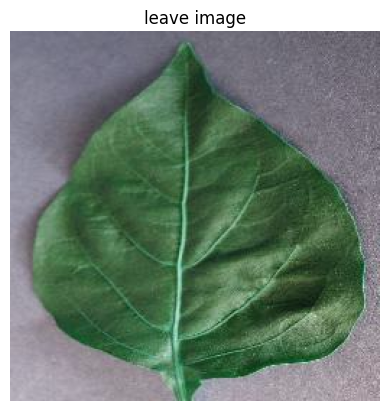

In [14]:
plt.imshow(img)
plt.title("leave image")
plt.axis('off')
# plt.show()

Text(0.5, 1.0, 'leave image')

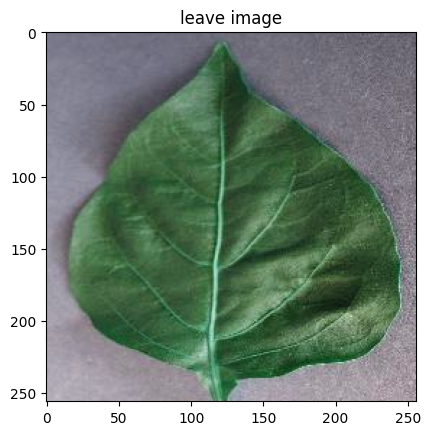

In [13]:
plt.imshow(img)
plt.title("leave image")

In [15]:
img_read = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [18]:
img_read[0][0]

array([136, 118, 118], dtype=uint8)

In [19]:
img[0][0]

array([118, 118, 136], dtype=uint8)

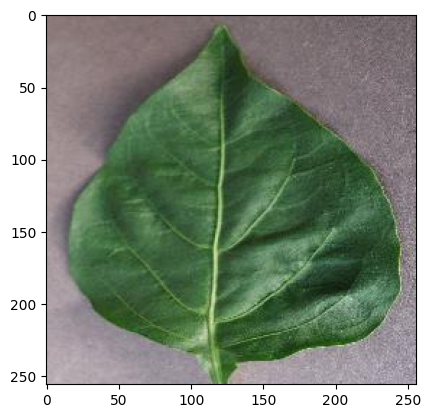

In [20]:
plt.imshow(img_read)

In [22]:
rgb_image = cv.imread('../input/images/rgb.png')
# plt.imshow(cv.imread(''))

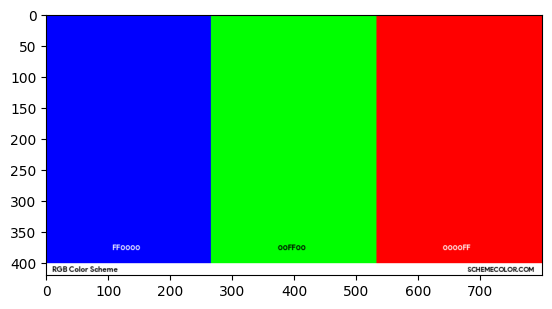

In [23]:
plt.imshow(rgb_image)

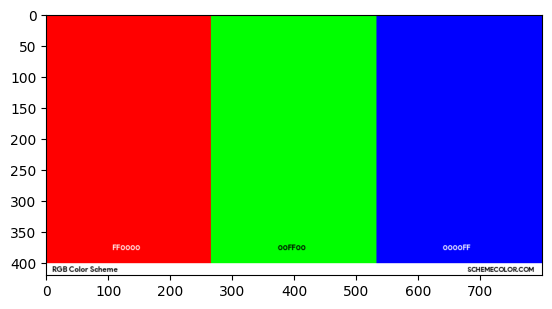

In [24]:
plt.imshow(cv.cvtColor(rgb_image, cv.COLOR_BGR2RGB))

In [25]:
tf.version

NameError: name 'tf' is not defined

In [30]:
import tensorflow as tf


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/macbookpro/Desktop/AI/competion/titanic/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/macbookpro/Desktop/AI/competion/titanic/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/macbookpro/Desktop/AI/competion/titanic/.venv/lib/python3.12/site-package

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

In [47]:
# tf.version
import matplotlib.pyplot as plt

In [32]:
print("open cv version", cv.__version__)

open cv version 4.11.0


create and display simple image

In [34]:
# create a blank image
import numpy as np
img2 = np.__version__

In [37]:
np.uint8

numpy.uint8

In [40]:
img2 = np.zeros((200, 200, 3), dtype=np.uint8)

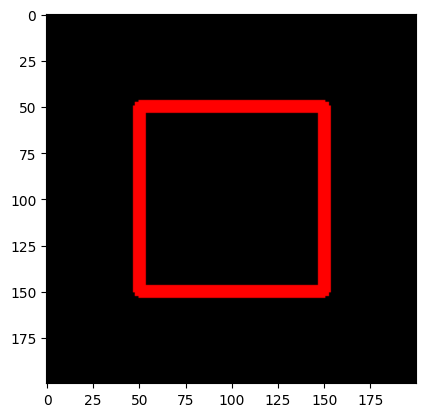

In [52]:
# img2.shape
plt.imshow(img2)

In [68]:
#draw a blue rectangle 
cv.rectangle(img2, (150,2250), (350,150), (255,0,0), thickness=5)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], shape=(200, 200, 3), dtype=uint8)

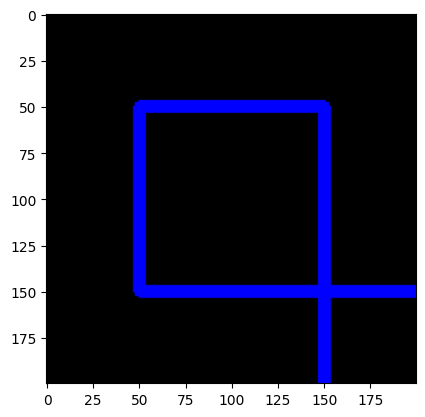

In [69]:
plt.imshow(cv.cvtColor(img2 , 4))


In [62]:
# plt.imshow(img2)

# plt.imshow(cv.cvtColor(img2 , 4))
# plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))

In [58]:
print(cv.COLOR_BAYER_BG2BGR)

46


In [70]:
from IPython.display import display, clear_output
import time


**(4) Using Neural Network**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Dense,Dropout,Flatten
from tensorflow.keras.models import Sequential

In [ ]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train[1]))
    Dense(32, activation='relu')
    Dense(1) #output layer
])

In [ ]:
# compile
model.compile(optimizer='adam', loss='mse', metric=['mae'])

In [ ]:
#train model
model.fit(X_train,y_train, epochs=50, batch_size=32, validation_split=0.2)

In [ ]:
#Evaluation
model.evaluate(X_test, y_test)

In [ ]:
y_predict_nn=model.predict(X_test)

In [ ]:
submitPredictions = model.predict(test_df)

In [ ]:
submission = pd.DataFrame({
    'Id':test_df["Id"],
    'SalePrice':submitPredictions
})

In [ ]:
submitPredictions.to_csv('../submissions/neural_network/submission.csv', index=False)

In [ ]:
print("Mean squared error", mean_squared_error(y_test, y_predict_nn))
print("Mean absolute error", mean_absolute_error(y_test, y_predict_nn))
print("r2 score", r2_score(y_test, y_predict_nn))

In [ ]:
from tensorflow import keras